### Learned Bloom Filter

A learned bloom filter uses a `learned oracle` as a pre-filtering stage in front of a standard bloom filter, called the back-up bloom filter. The oracle function $f(x)$ represents $Pr[x \in S]$. We set a threshold $\tau$ such that if $f(x) \geq \tau$, we return `True` for the query. Otherwise, if $f(x) < \tau$, we send the query to the back-up bloom filter. The back-up bloom filters job is to eliminate the possibility of getting false negatives. 

Given a set of elements $S$ from universe $U$, we can train the oracle using any ML model on the binary classification task with negative log likelihood loss function. The training dataset contains `(query, label)` pairs, with both positive and negative samples. 

Positive samples are all the elements from $S$ and negative samples are all the elements $U\setminus S$.

The back-up bloom filter is only meant to hold the subset of positive keys $\set{x \in S : f(x)<\tau}$ which are mis-classified by the oracle (i.e. False Negatives), instead of all keys in $S$, which can lead to significant space savings compared to a standard bloom filter on entire $S$.

We keep a held-out set of negative samples $Q$ with which we tune the threshold $\tau$, and the backup-bloom filter parameters, to acheive a desired false positive rate $\delta$. (More on this later...)

The goal is to create a 2-stage bloom filter that consumes less space than a standard bloom filter while achieving the same (or better) false positive rate.


In [74]:
import random
import torch
import sympy as sp
import math
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

random.seed(123)

In [2]:
class TwoUniversalHashFamily:
    def __init__(self, m, max_key):
        self.m = m  # Size of the hash table
        self.p = sp.nextprime(max_key)  # generate a large prime number, greater than any key
        self.a = random.randint(1, self.p-1)  # Choose a randomly
        self.b = random.randint(0, self.p-1)  # Choose b randomly

    def hash(self, k):
        return ((self.a * k + self.b) % self.p) % self.m
    
    def __call__(self, k):
        return self.hash(k)


class BloomStandard:
    def __init__(self, S, m, k=None, max_key=10000000):
        self.m = m
        if k is None:
            self.k = max(1,round((m/len(S)) * math.log(2)))  # optimal number of hash functions for a given m and n 
            print(f"Optimal number of hash functions: {self.k}")      
        else:
            self.k = k
        # draw k random hash functions from universal hash family
        self.h = [TwoUniversalHashFamily(m, max_key) for _ in range(self.k)]
        self.B = [0] * self.m

        # construct bit array
        for key in S:
            self.insert(key)
        print(f"Bloom filter constructed! Size: {self.m}, Number of hash functions: {self.k}")

    # insert new integer key into the bloom filter 
    def insert(self, key):
        for i in range(self.k):
            self.B[self.h[i](key)] = 1

    # poerform membership query for the given key
    def query(self, key):
        q = [0]*self.k
        for i in range(self.k):
            q[i] = self.B[self.h[i](key)]
        if 0 in q:
            return False
        else:
            return True    
            
    def __str__(self):
        return str(self.B)

Let's start with a simple dataset. Suppose the universe is $U = \set{0,1,2... 100000-1}$ and $S = \set{1000,1001,...,2000-1}$, i.e. the positive keys are all the integers in the range[1000,1999]. Then the target oracle function needs to be: 
$$
f(x) = 
\begin{cases} 
1 & \text{if } 1000 \leq x < 2000 \\
0 & \text{otherwise}
\end{cases}
$$

We will now try to learn this target function with a neural network with 1 hidden layer trained on binary classification task.

In [84]:
n_test = 1000
usize = 10000

# prepare training dataset
positive_samples_train = [(x,1) for x in range(1000,2000)]
all_negative_samples = [(x,0) for x in (list(range(0,1000)) + list(range(2000,usize)))]
# draw n_test negative samples for testing
negative_samples_test = random.sample(all_negative_samples, n_test)
# prepare training negative samples by removing n_test samples from all_negative_samples
negative_samples_train = [x for x in all_negative_samples if x not in negative_samples_test]

In [96]:
# define pytroch dataset class for training
class BloomDataset(torch.utils.data.Dataset):
    def __init__(self, positive_samples, negative_samples):
        if positive_samples is None:
            positive_samples = []
        self.samples = positive_samples + negative_samples
        random.shuffle(self.samples)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        x, y = self.samples[idx]
        # convert to tensor
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
        y = torch.tensor(y, dtype=torch.float32)
        return x, y


# define neural network with one hidden layer
class Oracle(torch.nn.Module):
    def __init__(self, hidden_dims=10, dropout_rate=0.2):
        super(Oracle, self).__init__()
        self.hidden_dims = hidden_dims
        self.hidden_layer = torch.nn.Linear(1, hidden_dims)
        self.output_layer = torch.nn.Linear(hidden_dims, 2)
        self.dropout = torch.nn.Dropout(dropout_rate)    

    def forward(self, x):
        x = torch.nn.ReLU()(self.hidden_layer(x))
        x = self.dropout(x)
        # compute output logits
        x = self.output_layer(x)
        return x
    

# training loop
def train(train_dataloader, model, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        pbar = tqdm(train_dataloader, desc="Epochs")
        num_total = 0
        num_correct = 0
        avg_loss = 0
        for batch in pbar:
            x, y = batch
            optimizer.zero_grad()
            outputs = model(x)
            loss = F.cross_entropy(outputs, y.long())
            loss.backward()
            optimizer.step()

            # compute moving average loss
            avg_loss = 0.9 * avg_loss + 0.1 * loss.item()

            # compute accuracy for batch precictions
            _, predicted = torch.max(outputs, 1)
            num_total += y.shape[0]
            num_correct += (predicted == y).sum().item()
            accuracy = num_correct / num_total

            pbar.set_description(f"Epoch {epoch + 1}, Train Loss: {avg_loss:.5f}, Train Accuracy: {accuracy: .5f}")


def evaluate(test_dataloader, model):
    num_total = 0
    num_correct = 0
    model.eval()
    with torch.no_grad():
        for x, y in test_dataloader:
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)
            num_total += y.shape[0]
            num_correct += (predicted == y).sum().item()
        accuracy = num_correct / num_total
    FP_rate = 1 - accuracy    
    print(f"Test FP rate: {FP_rate:.5f}")
    return accuracy

In [85]:
# model hyperparameters
batch_size = 128
hidden_dims = 100
num_epochs = 10

# define model and optimizer
model = Oracle(hidden_dims)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# prepare training dataloader
train_dataset = BloomDataset(positive_samples_train, negative_samples_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = BloomDataset(None, negative_samples_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [86]:
# train the model
train(train_dataloader, model, optimizer, num_epochs=250)

Epoch 1, Train Loss: 72.82753, Train Accuracy:  0.68389: 100%|██████████| 71/71 [00:00<00:00, 232.82it/s] 
Epoch 2, Train Loss: 58.81951, Train Accuracy:  0.84067: 100%|██████████| 71/71 [00:00<00:00, 219.39it/s]
Epoch 3, Train Loss: 50.75907, Train Accuracy:  0.85967: 100%|██████████| 71/71 [00:00<00:00, 210.30it/s]
Epoch 4, Train Loss: 50.63747, Train Accuracy:  0.85622: 100%|██████████| 71/71 [00:00<00:00, 189.85it/s]
Epoch 5, Train Loss: 57.24235, Train Accuracy:  0.86367: 100%|██████████| 71/71 [00:00<00:00, 200.09it/s]
Epoch 6, Train Loss: 55.08238, Train Accuracy:  0.85822: 100%|██████████| 71/71 [00:00<00:00, 211.43it/s]
Epoch 7, Train Loss: 58.81644, Train Accuracy:  0.85878: 100%|██████████| 71/71 [00:00<00:00, 218.67it/s]
Epoch 8, Train Loss: 50.78608, Train Accuracy:  0.85989: 100%|██████████| 71/71 [00:00<00:00, 244.91it/s]
Epoch 9, Train Loss: 52.70173, Train Accuracy:  0.86244: 100%|██████████| 71/71 [00:00<00:00, 223.91it/s]
Epoch 10, Train Loss: 47.13574, Train Accurac

In [97]:
model.eval()
with torch.no_grad():
    for x,_ in negative_samples_test[:100]:
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
        outputs = model(x)
        # apply softmax to get class probabilities
        predicted = torch.nn.Softmax(dim=0)(outputs)
        print(f"x: {int(x.item())}, Probs: {predicted.tolist()}")
    

x: 8004, Probs: [0.9997996687889099, 0.00020037156355101615]
x: 6884, Probs: [0.9990776777267456, 0.0009223427623510361]
x: 9577, Probs: [0.9999765157699585, 2.3426457119057886e-05]
x: 7464, Probs: [0.9995817542076111, 0.00041828438406810164]
x: 2796, Probs: [0.803819477558136, 0.1961805373430252]
x: 8899, Probs: [0.9999408721923828, 5.9064794186269864e-05]
x: 5912, Probs: [0.9965351819992065, 0.003464829409494996]
x: 4508, Probs: [0.9769375324249268, 0.02306247502565384]
x: 8655, Probs: [0.9999176263809204, 8.242293552029878e-05]
x: 6482, Probs: [0.9984046816825867, 0.0015953158726915717]
x: 819, Probs: [0.7839083671569824, 0.21609164774417877]
x: 4466, Probs: [0.9756060242652893, 0.024394024163484573]
x: 3802, Probs: [0.941737949848175, 0.05826206132769585]
x: 4072, Probs: [0.9589625000953674, 0.041037436574697495]
x: 5654, Probs: [0.995080828666687, 0.004919129423797131]
x: 6999, Probs: [0.9992111921310425, 0.0007887380779720843]
x: 6150, Probs: [0.997492790222168, 0.002507185796275

In [98]:
# evaluate the model
evaluate(test_dataloader, model)

# compute model predictions for all universe items
universe = list(range(0,usize))
predictions = []
model.eval()
with torch.no_grad():
    #for x,_ in negative_samples_test[:100]
    for x in universe:
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
        outputs = model(x)
        # apply softmax to get class probabilities
        predicted = torch.nn.Softmax(dim=0)(outputs)
        #print(f"x: {x}, Logits: {outputs}, Predicted: {predicted}")
        predictions.append(predicted[1].item())



Test FP rate: 0.00300


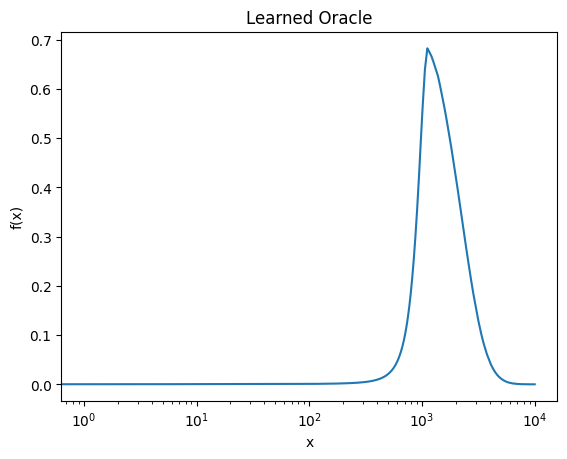

In [99]:
# plot the model predictions
plt.plot(universe, predictions)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Learned Oracle')

# log scale on x axis
plt.xscale('log')